In [1]:
# !pip install gatree --user
# !pip install fairlearn

In [2]:
import pandas as pd
import numpy as np
from fairlearn.datasets import fetch_adult
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from gatree.methods.gatreeclustering import GATreeClustering
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

C:\Users\Zala\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
def fair_fitness_function_SS(root, **fitness_function_kwargs):
    if len(set(root.y_pred)) < fitness_function_kwargs['min_clusters']:
        return 5

    y_pred = pd.Series(root.y_pred)
    SSS = []
    Z = fitness_function_kwargs['fitness_Z']
    X = fitness_function_kwargs['fitness_X']

    for z_i in Z.unique():
        y_i = y_pred.loc[Z == z_i]
        X_i = X.loc[Z == z_i]
        if len(set(y_i)) > 1:
            SS_i = silhouette_score(X_i, y_i)
            SSS.append(SS_i)
        else:
            SSS.append(-1)

    SS_max = (max(SSS) + 1) / 2
    SS_min = (min(SSS) + 1) / 2
    SS_diff = abs(SS_max - SS_min)

    return 1 - ((silhouette_score(fitness_function_kwargs['fitness_X'], root.y_pred) + 1) / 2) + (0.002 * root.size()) \
        + (SS_diff / 2)

In [4]:
def fair_fitness_function_ratios(root, **fitness_function_kwargs):
    if len(set(root.y_pred)) < fitness_function_kwargs['min_clusters']:
        return 5

    fitness_Z = fitness_function_kwargs['fitness_Z']
    y_pred = root.y_pred

    global_ratios = fitness_Z.value_counts(normalize=True).reset_index()
    global_ratios.columns = ['Z', 'global_ratio']

    data = pd.DataFrame({
        'y_pred': y_pred,
        'Z': fitness_Z
    })

    cluster_counts = data.groupby(['y_pred', 'Z']).size().reset_index(name='count')
    total_counts = cluster_counts.groupby('y_pred')['count'].transform('sum')
    cluster_counts['cluster_ratio'] = cluster_counts['count'] / total_counts

    merged = cluster_counts.merge(global_ratios, on='Z', how='left')

    merged['abs_diff'] = (merged['cluster_ratio'] - merged['global_ratio']).abs()

    aggregated_diff = merged.groupby('y_pred')['abs_diff'].sum().reset_index()
    aggregated_diff.columns = ['y_pred', 'sum_abs_diff']

    abs_diff_sum = aggregated_diff['sum_abs_diff'].sum()

    return 1 - ((silhouette_score(fitness_function_kwargs['fitness_X'], root.y_pred) + 1) / 2) + (0.002 * root.size()) + abs_diff_sum

In [5]:
adult = fetch_adult()

X = pd.DataFrame(adult.data, columns=adult.feature_names)
y = pd.Series(adult.target, name='target')

X.dropna(inplace=True)

sample_size = min(3000, len(X))

X.drop(columns=['workclass', 'occupation', 'native-country'], axis=1, inplace=True)
X = X.sample(n=sample_size, random_state=32)

sensitive_data = X['sex']

label_to_number = {label: i for i, label in enumerate(sensitive_data.unique())}

Z = sensitive_data.map(label_to_number)

min_clusters = 3
max_clusters = 6

Z = Z.reset_index(drop=True)
X = X.reset_index(drop=True)

In [6]:
sensitive_data

35115      Male
1174     Female
32172      Male
26705      Male
45569    Female
          ...  
18187    Female
35507      Male
32489      Male
13604      Male
2896     Female
Name: sex, Length: 3000, dtype: category
Categories (2, object): ['Female', 'Male']

In [7]:
tree_results_Z = [
    GATreeClustering(n_jobs=16, random_state=32, min_clusters=min_clusters, max_clusters=max_clusters),
    GATreeClustering(n_jobs=16, random_state=32, min_clusters=min_clusters, max_clusters=max_clusters, fitness_function=fair_fitness_function_SS),
    GATreeClustering(n_jobs=16, random_state=32, min_clusters=min_clusters, max_clusters=max_clusters, fitness_function=fair_fitness_function_ratios)
]
tree_results_no_Z = [
    GATreeClustering(n_jobs=16, random_state=32, min_clusters=min_clusters, max_clusters=max_clusters),
    GATreeClustering(n_jobs=16, random_state=32, min_clusters=min_clusters, max_clusters=max_clusters, fitness_function=fair_fitness_function_SS),
    GATreeClustering(n_jobs=16, random_state=32, min_clusters=min_clusters, max_clusters=max_clusters, fitness_function=fair_fitness_function_ratios)
]

In [8]:
tree_results_Z[0].min_clusters

3

In [9]:
X_train_Z = pd.get_dummies(X)

X_train_B = X.drop(columns=['sex'], axis=1)
X_train_B = pd.get_dummies(X_train_B)

In [10]:
for i in range(2):
    if i == 0:
        fitness_function_kwargs = {
            'min_clusters': min_clusters,
            'fitness_X': X_train_Z,
            'fitness_Z': Z
        }
        
        for index, value in enumerate(tree_results_Z):
            tree_results_Z[index].fit(X=X_train_Z, population_size=100, max_iter=100, fitness_function_kwargs=fitness_function_kwargs)
    else:
        fitness_function_kwargs = {
            'min_clusters': min_clusters,
            'fitness_X': X_train_B,
            'fitness_Z': Z
        }
        
        for index, value in enumerate(tree_results_no_Z):
            tree_results_no_Z[index].fit(X=X_train_B, population_size=100, max_iter=100, fitness_function_kwargs=fitness_function_kwargs)

In [11]:
global_ratios = Z.value_counts(normalize=True).reset_index()
global_ratios.columns = ['Z', 'global_ratio']

In [12]:
def calculate_SS_for_specific_group(X_group, y_pred, group):
    filtered_df = X[X['sex'] == group]
    
    indexes = filtered_df.index
    
    data2 = {
        'y_pred': y_pred
    }
    
    X_group = X_group.iloc[indexes]
    
    df2 = pd.DataFrame(data2)
    
    df2 = df2.iloc[indexes]
    
    return silhouette_score(X_group, df2['y_pred'])

print(calculate_SS_for_specific_group(X_train_Z, tree_results_Z[0]._tree.y_pred, 'Male'))
print(calculate_SS_for_specific_group(X_train_Z, tree_results_Z[0]._tree.y_pred, 'Female'))

0.7658718057835433
0.8282545806168653


In [13]:
def calculate_ratio_for_specific_group(X_group, y_pred, group):
    data = pd.DataFrame({
        'y_pred': y_pred,
        'Z': Z
    })

    cluster_counts = data.groupby(['y_pred', 'Z']).size().reset_index(name='count')
    total_counts = cluster_counts.groupby('y_pred')['count'].transform('sum')
    cluster_counts['cluster_ratio'] = cluster_counts['count'] / total_counts

    merged = cluster_counts.merge(global_ratios, on='Z', how='left')

    merged['abs_diff'] = (merged['cluster_ratio'] - merged['global_ratio']).abs()
    
    result = merged[merged['Z'] == group][['y_pred', 'cluster_ratio']].set_index(keys=['y_pred'], drop=True)

    return result['cluster_ratio'].to_dict()

print(calculate_ratio_for_specific_group(X_train_Z, tree_results_Z[0]._tree.y_pred, 0))
print(calculate_ratio_for_specific_group(X_train_Z, tree_results_Z[0]._tree.y_pred, 1))

{1: 0.0, 2: 0.75, 4: 0.6604340567612688}
{1: 1.0, 2: 0.25, 4: 0.33956594323873124}


In [14]:
results_Z = {
    'SS': [
        silhouette_score(X_train_Z, tree_results_Z[0]._tree.y_pred), 
        silhouette_score(X_train_Z, tree_results_Z[1]._tree.y_pred), 
        silhouette_score(X_train_Z, tree_results_Z[2]._tree.y_pred)
    ],
    'SSmoski': [
        calculate_SS_for_specific_group(X_train_Z, tree_results_Z[0]._tree.y_pred, 'Male'),
        calculate_SS_for_specific_group(X_train_Z, tree_results_Z[1]._tree.y_pred, 'Male'), 
        calculate_SS_for_specific_group(X_train_Z, tree_results_Z[2]._tree.y_pred, 'Male')
    ],
    'SSzensk': [
        calculate_SS_for_specific_group(X_train_Z, tree_results_Z[0]._tree.y_pred, 'Female'),
        calculate_SS_for_specific_group(X_train_Z, tree_results_Z[1]._tree.y_pred, 'Female'), 
        calculate_SS_for_specific_group(X_train_Z, tree_results_Z[2]._tree.y_pred, 'Female')
    ],
    'Rmoski': [
        calculate_ratio_for_specific_group(X_train_Z, tree_results_Z[0]._tree.y_pred, 0),
        calculate_ratio_for_specific_group(X_train_Z, tree_results_Z[1]._tree.y_pred, 0),
        calculate_ratio_for_specific_group(X_train_Z, tree_results_Z[2]._tree.y_pred, 0)
    ],
    'Rzenske': [
        calculate_ratio_for_specific_group(X_train_Z, tree_results_Z[0]._tree.y_pred, 1),
        calculate_ratio_for_specific_group(X_train_Z, tree_results_Z[1]._tree.y_pred, 1),
        calculate_ratio_for_specific_group(X_train_Z, tree_results_Z[2]._tree.y_pred, 1)
    ],
}

results_no_Z = {
    'SS': [
        silhouette_score(X_train_B, tree_results_no_Z[0]._tree.y_pred), 
        silhouette_score(X_train_B, tree_results_no_Z[1]._tree.y_pred), 
        silhouette_score(X_train_B, tree_results_no_Z[2]._tree.y_pred)
    ],
    'SSmoski': [
        calculate_SS_for_specific_group(X_train_B, tree_results_no_Z[0]._tree.y_pred, 'Male'),
        calculate_SS_for_specific_group(X_train_B, tree_results_no_Z[1]._tree.y_pred, 'Male'), 
        calculate_SS_for_specific_group(X_train_B, tree_results_no_Z[2]._tree.y_pred, 'Male')
    ],
    'SSzensk': [
        calculate_SS_for_specific_group(X_train_B, tree_results_no_Z[0]._tree.y_pred, 'Female'),
        calculate_SS_for_specific_group(X_train_B, tree_results_no_Z[1]._tree.y_pred, 'Female'), 
        calculate_SS_for_specific_group(X_train_B, tree_results_no_Z[2]._tree.y_pred, 'Female')
    ],
    'Rmoski': [
        calculate_ratio_for_specific_group(X_train_B, tree_results_no_Z[0]._tree.y_pred, 0),
        calculate_ratio_for_specific_group(X_train_B, tree_results_no_Z[1]._tree.y_pred, 0),
        calculate_ratio_for_specific_group(X_train_B, tree_results_no_Z[2]._tree.y_pred, 0)
    ],
    'Rzenske': [
        calculate_ratio_for_specific_group(X_train_B, tree_results_no_Z[0]._tree.y_pred, 1),
        calculate_ratio_for_specific_group(X_train_B, tree_results_no_Z[1]._tree.y_pred, 1),
        calculate_ratio_for_specific_group(X_train_B, tree_results_no_Z[2]._tree.y_pred, 1)
    ],
}

In [15]:
data = [
    results_Z['SS'] + results_no_Z['SS'],
    results_Z['SSmoski'] + results_no_Z['SSmoski'],
    results_Z['SSzensk'] + results_no_Z['SSzensk'],
    results_Z['Rmoski'] + results_no_Z['Rmoski'],
    results_Z['Rzenske'] + results_no_Z['Rzenske'],
]

row_labels = ['SS', 'SSmoski', 'SSzensk', 'Rmoski', 'Rzenske']

columns = pd.MultiIndex.from_product(
    [['Z_sex', 'B_sex'], ['GAC', 'GAFC1', 'GAFC2']],
    names=["Group", "Tree Type"]
)

df = pd.DataFrame(data, columns=columns, index=row_labels)
df

Group                                          Z_sex  \
Tree Type                                        GAC   
SS                                          0.786993   
SSmoski                                     0.765872   
SSzensk                                     0.828255   
Rmoski      {1: 0.0, 2: 0.75, 4: 0.6604340567612688}   
Rzenske    {1: 1.0, 2: 0.25, 4: 0.33956594323873124}   

Group                                                         \
Tree Type                                              GAFC1   
SS                                                  0.487239   
SSmoski                                             0.485838   
SSzensk                                             0.489085   
Rmoski     {2: 0.6709183673469388, 3: 0.6625704045058883,...   
Rzenske    {2: 0.32908163265306123, 3: 0.3374295954941116...   

Group                                                         \
Tree Type                                              GAFC2   
SS                                                  0.485722   
SSmoski                                              0.47182   
SSzensk                                             0.512103   
Rmoski     {0: 0.6580779944289693, 1: 0.6610169491525424,...   
Rzenske    {0: 0.34192200557103064, 1: 0.3389830508474576...   

Group                                         B_sex  \
Tree Type                                       GAC   
SS                                          0.67323   
SSmoski                                    0.582768   
SSzensk                                    0.826457   
Rmoski      {0: 0.6599866399465598, 1: 0.8, 3: 1.0}   
Rzenske    {0: 0.34001336005344024, 1: 0.2, 3: 0.0}   

Group                                                         \
Tree Type                                              GAFC1   
SS                                                  0.492748   
SSmoski                                             0.492083   
SSzensk                                             0.492791   
Rmoski     {1: 0.6429872495446266, 3: 0.6647901740020471,...   
Rzenske    {1: 0.3570127504553734, 3: 0.3352098259979529,...   

Group                                                         
Tree Type                                              GAFC2  
SS                                                  0.519151  
SSmoski                                             0.556865  
SSzensk                                             0.358302  
Rmoski     {2: 0.6614658925979681, 3: 0.6666666666666666,...  
Rzenske    {2: 0.33853410740203194, 3: 0.3333333333333333...

In [16]:
print(df['Z_sex']['GAC']['Rmoski'])
print(df['Z_sex']['GAFC1']['Rmoski'])
print(df['Z_sex']['GAFC2']['Rmoski'])

{1: 0.0, 2: 0.75, 4: 0.6604340567612688}
{2: 0.6709183673469388, 3: 0.6625704045058883, 5: 0.6473282442748092}
{0: 0.6580779944289693, 1: 0.6610169491525424, 5: 0.6628099173553719}


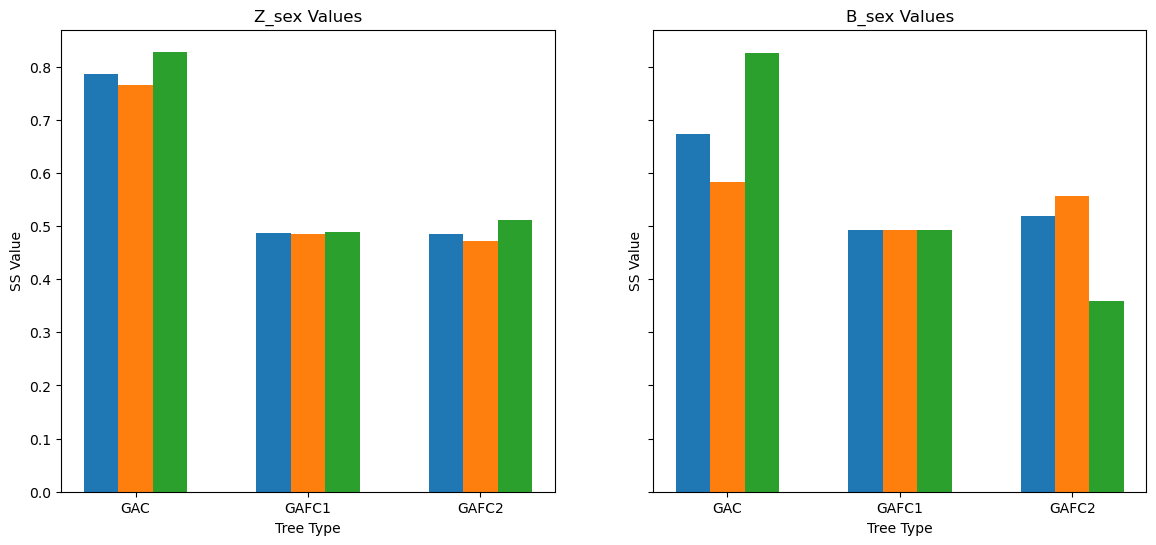

In [17]:
tree_types = ["GAC", "GAFC1", "GAFC2"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, sex in zip(axes, ["Z_sex", "B_sex"]):
    x = np.arange(len(tree_types))
    width = 0.2
    for i, group in enumerate(tree_types):
        values = [df[(sex, tree_type)][i] for tree_type in tree_types]
        ax.bar(x + i * width, values, width, label=group)
    
    ax.set_xticks(x + width)
    ax.set_xticklabels(tree_types)
    ax.set_title(f"{sex} Values")
    ax.set_xlabel("Tree Type")
    ax.set_ylabel("SS Value")

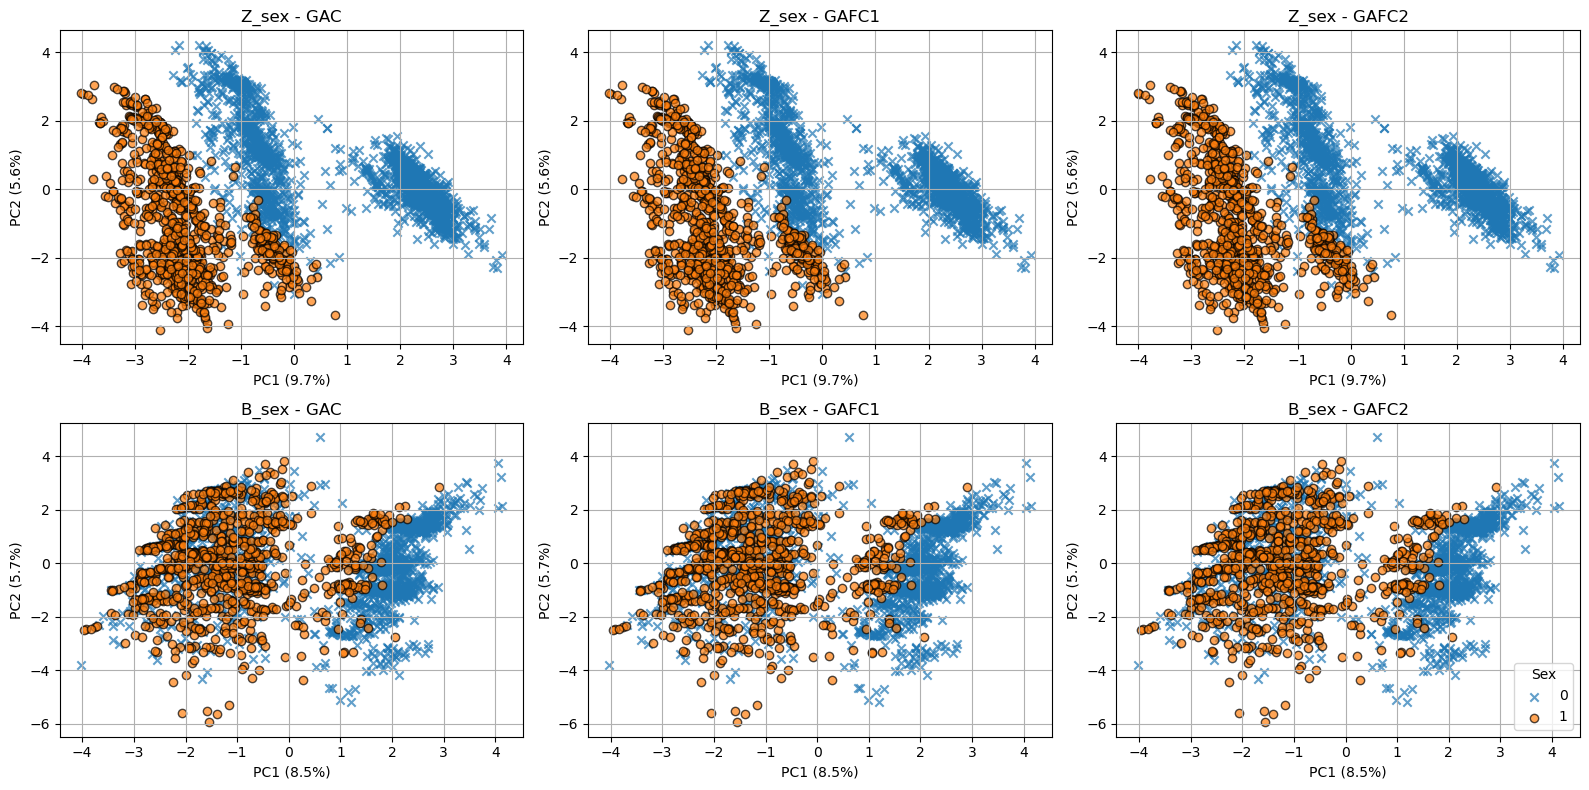

In [18]:
tree_types = ["GAC", "GAFC1", "GAFC2"]
groups = ["Z_sex", "B_sex"]

marker_map = {
    0: 'x',
    1: "o"
}

fig, axes = plt.subplots(len(groups), len(tree_types), figsize=(16, 8))

for i, group in enumerate(groups):
    for j, tree_type in enumerate(tree_types):
        data = X_train_Z
        if group == 'B_sex':
            data = X_train_B
        labels = Z

        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)

        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(data_scaled)
        explained_variance = pca.explained_variance_ratio_

        ax = axes[i, j]
        for label in labels.unique():
            idx = labels == label
            ax.scatter(
                pca_result[idx, 0],
                pca_result[idx, 1],
                alpha=0.7,
                label=label,
                marker=marker_map.get(label, "o"),
                edgecolors='k'
            )
        
        ax.set_title(f"{group} - {tree_type}")
        ax.set_xlabel(f"PC1 ({explained_variance[0]*100:.1f}%)")
        ax.set_ylabel(f"PC2 ({explained_variance[1]*100:.1f}%)")
        ax.grid(True)
        if i == len(groups) - 1 and j == len(tree_types) - 1:
            ax.legend(title="Sex", loc="lower right")

plt.tight_layout()
plt.show()

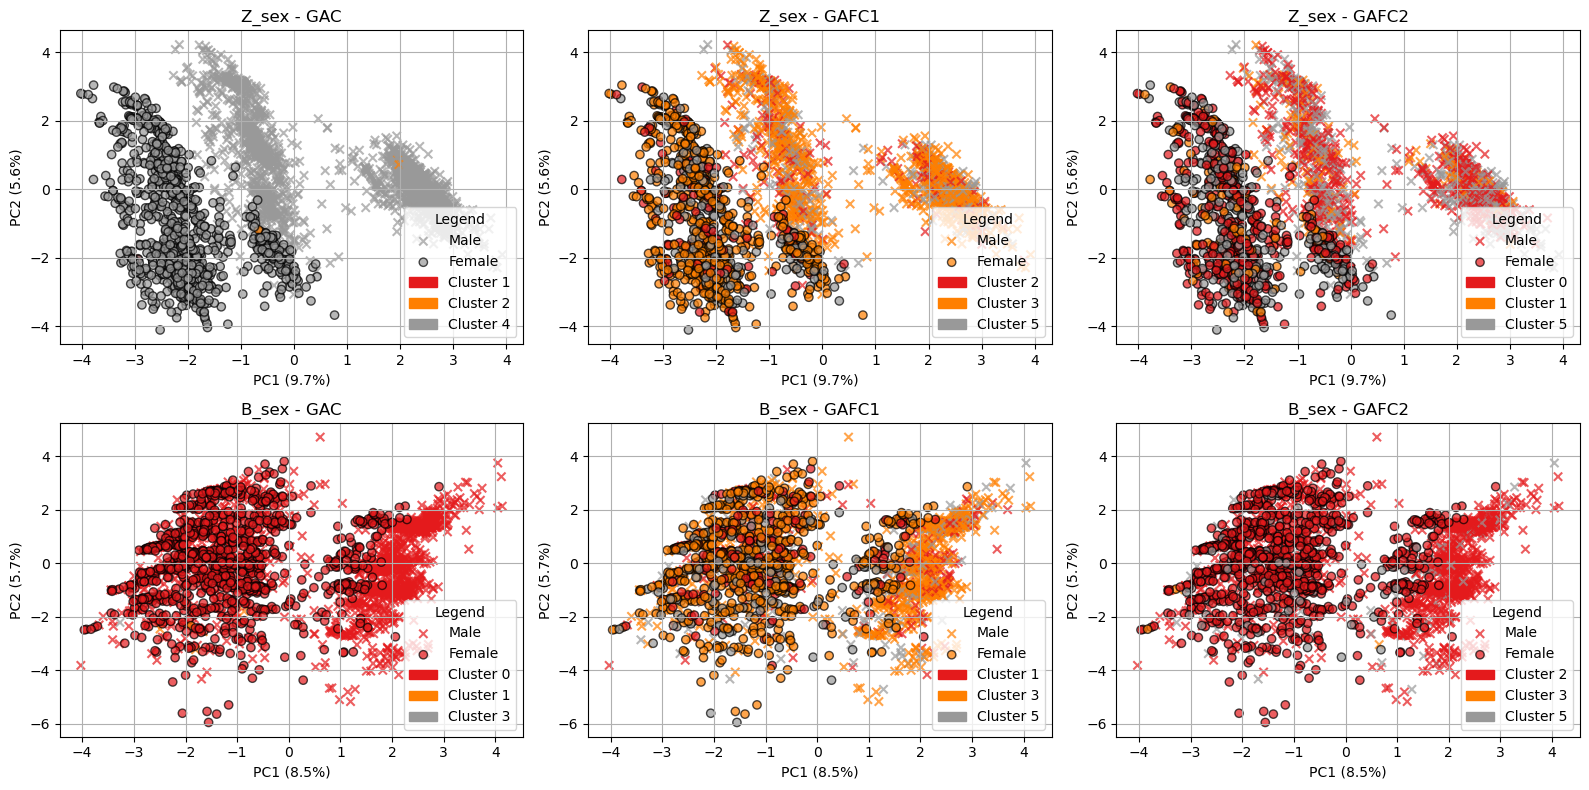

In [19]:
tree_types = ["GAC", "GAFC1", "GAFC2"]
groups = ["Z_sex", "B_sex"]

marker_map = {
    0: 'x',  # Male
    1: "o"   # Female
}

fig, axes = plt.subplots(len(groups), len(tree_types), figsize=(16, 8))

for i, group in enumerate(groups):
    for j, tree_type in enumerate(tree_types):
        y_pred = tree_results_Z[j]._tree.y_pred
        if i == 1:
            y_pred = tree_results_no_Z[j]._tree.y_pred
            
        y_pred = np.asarray(y_pred)
        
        data = X_train_Z if group == 'Z_sex' else X_train_B
        labels = Z
        
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)

        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(data_scaled)
        explained_variance = pca.explained_variance_ratio_
        
        cmap = cm.get_cmap('Set1', len(set(y_pred)))
        unique_clusters = np.unique(y_pred)
        cluster_colors = {cluster: cmap(i) for i, cluster in enumerate(unique_clusters)}

        ax = axes[i, j]
        for label in np.unique(labels):
            idx = labels == label
            ax.scatter(
                pca_result[idx, 0],
                pca_result[idx, 1],
                alpha=0.7,
                label=f"{'Male' if label == 0 else 'Female'}",
                marker=marker_map.get(label, "o"),
                c=[cluster_colors[c] for c in y_pred[idx]],
                edgecolors='k'
            )
            
        cluster_patches = [
            mpatches.Patch(color=cluster_colors[cluster], label=f"Cluster {cluster}")
            for cluster in unique_clusters
        ]
        
        ax.set_title(f"{group} - {tree_type}")
        ax.set_xlabel(f"PC1 ({explained_variance[0]*100:.1f}%)")
        ax.set_ylabel(f"PC2 ({explained_variance[1]*100:.1f}%)")
        ax.grid(True)
        
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            handles=handles + cluster_patches,
            title="Legend",
            loc="lower right"
        )

plt.tight_layout()
plt.show()